CASED でやる

fold 6 で

In [1]:
from datetime import datetime

In [2]:
TRAIN_I_FOLD = 6

N_GRAD_POOL = 8

MIN_LR = 1e-6
MAX_LR = 5e-6

RESULT_PATH = f"../models/large-CASED-2-{datetime.now().strftime('%Y%m%d-%H%M%S')}"

MAX_BATCH_SIZE = 256

OUT_DROPOUT = 0.3

BERT_HIDDEN_SIZE = 1024

BERT_MODEL_PATH = 'bert-large-cased'
BERT_DO_LOWER = 'uncased' in BERT_MODEL_PATH

batch_size = 4
n_seeds = 1
n_splits = 10
n_epochs = 2

VAL_INTERVAL_RATIO = 0.25

TRAIN_ON_N_SPLITS = 1


RESULT_TXT = f"bert-{datetime.now().strftime('%Y%m%d-%H%M%S')}.txt"

SUBGROUP_NEGATIVE_WEIGHT_COEF = 1

MAX_LEN = 220

DEBUG = False

if DEBUG:
    DEBUG_DATA_SIZE = 1000
    n_seeds = 1
    n_splits = 10
    n_epochs = 3

In [3]:
n_validation = int(n_epochs / VAL_INTERVAL_RATIO)
n_validation

8

In [4]:
RESULT_TXT

'bert-20190606-100036.txt'

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['sentencefeaturesoov', 'crawl_emb_nocomp.pickle', 'jigsaw-unintended-bias-in-toxicity-classification', 'crawl_emb_processed_lz4.joblib', 'x-train-tokenized', 'crawl_emb_nocomp.joblib', 'crawl_emb_processed.joblib', 'bert-pretrained-models', 'fasttext-crawl-300d-2m', 'jigsaw-x-train-bert-tokenized', 'glove840b300dtxt', 'roov-crawl.pickle']


In [6]:
import numpy as np
import pandas as pd
import os
import time
import gc
import random
from tqdm import tqdm
tqdm.pandas()
from contextlib import contextmanager
from fastprogress import master_bar, progress_bar
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [7]:
if not os.path.exists(RESULT_PATH):
    os.mkdir(RESULT_PATH)

In [8]:
# 9.9G

if DEBUG:
    train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', nrows=DEBUG_DATA_SIZE)
else:
    train = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
y_train = np.where(train['target'] >= 0.5, 1, 0)
y_aux_train = train[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']]


In [9]:
if DEBUG:
    sentence_df = pd.read_csv('../input/sentencefeaturesoov/sentence_features.csv', nrows=DEBUG_DATA_SIZE)
else:
    sentence_df = pd.read_csv('../input/sentencefeaturesoov/sentence_features.csv')

In [10]:
sentence_df.head()

,word_count,n_upper,n_unique,n_ex,n_que,n_puncts,n_prof,n_oov,n_upper_ratio,n_unique_ratio,n_ex_ratio,n_que_ratio,n_puncts_ratio,n_prof_ratio,n_oov_ratio
0,26,3,24,1,2,6,0,0,0.115385,0.923077,0.038462,0.076923,0.230769,0.0,0.0
1,29,3,27,3,0,6,0,0,0.103448,0.931034,0.103448,0.000000,0.206897,0.0,0.0
2,19,2,19,1,0,3,0,0,0.105263,1.000000,0.052632,0.000000,0.157895,0.0,0.0
3,19,3,17,0,2,2,0,0,0.157895,0.894737,0.000000,0.105263,0.105263,0.0,0.0
4,9,0,9,0,0,1,0,0,0.000000,1.000000,0.000000,0.000000,0.111111,0.0,0.0


In [11]:
sentence_feature_mat = sentence_df.drop(columns=['n_oov']).values
del sentence_df
gc.collect()

0

In [12]:
TOXICITY_COLUMN = 'target'
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

subgroup_bool_train = train[identity_columns].fillna(0)>=0.5
toxic_bool_train = train[TOXICITY_COLUMN].fillna(0)>=0.5
subgroup_negative_mask = subgroup_bool_train.values.sum(axis=1).astype(bool) & ~toxic_bool_train

sample_weight = np.ones((y_train.shape[0],))
sample_weight += SUBGROUP_NEGATIVE_WEIGHT_COEF * subgroup_negative_mask

del subgroup_bool_train, toxic_bool_train, subgroup_negative_mask
gc.collect()

y_train_torch = torch.tensor(np.concatenate([y_train[:, np.newaxis], y_aux_train, sample_weight[:, np.newaxis]], axis=1), dtype=torch.float32).cuda()

In [13]:

import torch
from pytorch_pretrained_bert import convert_tf_checkpoint_to_pytorch
from pytorch_pretrained_bert import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)


In [14]:
%%time
if BERT_DO_LOWER:
    if 'large' in BERT_MODEL_PATH:
        tokenized_path = '../input/jigsaw-x-train-bert-tokenized/x_train_tockenized_uncased_large.csv'
        
    else:
        tokenized_path = '../input/jigsaw-x-train-bert-tokenized/x_train_tockenized.csv'
else:
    if 'large' in BERT_MODEL_PATH:
        tokenized_path = '../input/jigsaw-x-train-bert-tokenized/x_train_tockenized_CASED_large.csv'
    else:
        tokenized_path = '../input/jigsaw-x-train-bert-tokenized/x_train_tockenized_cased.csv'
    

if DEBUG:
    df_x_tokenized = pd.read_csv(tokenized_path,
                                 header=None, nrows=DEBUG_DATA_SIZE)
else:
    df_x_tokenized = pd.read_csv(tokenized_path,
                                 header=None)


CPU times: user 4.66 s, sys: 321 ms, total: 4.99 s
Wall time: 8.39 s


In [15]:
df_x_tokenized.head()

,0
0,"[CLS] This is so cool . It ' s like , ' would ..."
1,[CLS] Thank you ! ! This would make my life a ...
2,[CLS] This is such an urgent design problem ; ...
3,[CLS] Is this something I ' ll be able to inst...
4,[CLS] ha ##ha you guys are a bunch of loser ##...


In [16]:
%%time
x_train_tockenized = df_x_tokenized[0].progress_apply(lambda x: x.split())

100%|██████████| 1804874/1804874 [00:15<00:00, 118698.76it/s]

CPU times: user 13.9 s, sys: 1.37 s, total: 15.3 s
Wall time: 15.2 s


In [17]:
del df_x_tokenized
gc.collect()

0

In [18]:
x_train_tockenized.head()

0    [[CLS], This, is, so, cool, ., It, ', s, like,...
1    [[CLS], Thank, you, !, !, This, would, make, m...
2    [[CLS], This, is, such, an, urgent, design, pr...
3    [[CLS], Is, this, something, I, ', ll, be, abl...
4    [[CLS], ha, ##ha, you, guys, are, a, bunch, of...
Name: 0, dtype: object

In [19]:
%%time

tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_PATH, do_lower_case=BERT_DO_LOWER, cache_dir='../bert-cache')
x_train_indexed = x_train_tockenized.progress_apply(lambda x: tokenizer.convert_tokens_to_ids(x[:MAX_LEN]))

INFO:pytorch_pretrained_bert.tokenization:loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased-vocab.txt from cache at ../bert-cache/cee054f6aafe5e2cf816d2228704e326446785f940f5451a5b26033516a4ac3d.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
100%|██████████| 1804874/1804874 [00:32<00:00, 55419.61it/s]

CPU times: user 31.2 s, sys: 1.04 s, total: 32.3 s
Wall time: 33.6 s


In [20]:
del x_train_tockenized, tokenizer
gc.collect()

0

In [21]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

57802752

In [22]:
import math
class DynamicBucketIterator(object):
    def __init__(self, data, label, capacity, pad_token, shuffle, length_quantile, max_batch_size, for_bert):
        self.data = data
        self.label = label
        self.pad_token = pad_token
        self.capacity = capacity
        self.shuffle = shuffle
        self.length_quantile = length_quantile
        self.for_bert = for_bert
        
        self.index_sorted = sorted(range(len(self.data)), key=lambda i: len(self.data[i]))
        
        old_separator_index = 0
        self.separator_index_list = [0]
        for i_sample in range(len(self.data)):
            sample_index = self.index_sorted[i_sample]
            sample = self.data[sample_index]
            current_batch_size = i_sample - old_separator_index + 1
            if min(len(sample), MAX_LEN) * current_batch_size <= self.capacity and current_batch_size <= max_batch_size:
                pass
            else:
                old_separator_index = i_sample
                self.separator_index_list.append(i_sample)
                
        self.separator_index_list.append(len(self.data)) # [0, ..., start_separator_index, end_separator_index, ..., len(data)]
        
        if not self.shuffle:
            self.bucket_index = range(self.__len__())
        
        self.reset_index()

    def reset_index(self):
        self.i_batch = 0
        
        if self.shuffle:
            self.index_sorted = sorted(np.random.permutation(len(self.data)), key=lambda i: len(self.data[i]))
            self.bucket_index = np.random.permutation(self.__len__())
    
    def __len__(self):
        return len(self.separator_index_list) - 1
    
    def __iter__(self):
        return self
    
    def __next__(self):
        try:
            i_bucket = self.bucket_index[self.i_batch]
        except IndexError as e:
            self.reset_index()
            raise StopIteration
            
        start_index, end_index = self.separator_index_list[i_bucket : i_bucket + 2]
        
        index_batch = self.index_sorted[start_index : end_index]

        raw_batch_data = [self.data[i] for i in index_batch]
        
        batch_label = self.label[index_batch]
        
        max_len = int(math.ceil(np.quantile([len(x) for x in raw_batch_data], self.length_quantile)))
        max_len = min([max_len, MAX_LEN])
        if max_len == 0:
            max_len = 1
        
        if self.for_bert:
            segment_id_batch = np.zeros((len(raw_batch_data), max_len))
            padded_batch = []
            input_mask_batch = []
            for sample in raw_batch_data:
                input_mask = [1] * len(sample) + [0] * (max_len - len(sample))
                input_mask_batch.append(input_mask[:max_len])

                sample = sample + [self.pad_token for _ in range(max_len - len(sample))]
                padded_batch.append(sample[:max_len])

            self.i_batch += 1

            return padded_batch, segment_id_batch, input_mask_batch, batch_label, index_batch
        
        else:
            padded_batch = []
            for sample in raw_batch_data:
                sample = sample + [self.pad_token for _ in range(max_len - len(sample))]
                padded_batch.append(sample[:max_len])

            self.i_batch += 1

            return padded_batch, batch_label, index_batch
        

In [23]:

class NeuralNet(nn.Module):
    def __init__(self, num_aux_targets, num_sentence_features):
        super(NeuralNet, self).__init__()
        self.bert_model = BertModel.from_pretrained(BERT_MODEL_PATH, cache_dir='../bert-cache')
        self.dropout = nn.Dropout(OUT_DROPOUT)
        
        self.linear_sentence1 = nn.Linear(num_sentence_features, num_sentence_features)
        
        n_hidden = BERT_HIDDEN_SIZE + num_sentence_features
        self.linear1 = nn.Linear(n_hidden, n_hidden)
        
        self.linear_out = nn.Linear(n_hidden, 1)
        self.linear_aux_out = nn.Linear(n_hidden, num_aux_targets)
        
    def forward(self, x_features, sentence_features):
        
        _, bert_output = self.bert_model(*x_features, output_all_encoded_layers=False)
        
        bert_output = self.dropout(bert_output)
        
        h_sentence = self.linear_sentence1(sentence_features)
        
        h_cat = torch.cat((bert_output, h_sentence), 1)
        
        h_conc_linear1  = F.relu(self.linear1(h_cat))
        
        hidden = h_cat + h_conc_linear1
        
        result = self.linear_out(hidden)
        aux_result = self.linear_aux_out(hidden)
        out = torch.cat([result, aux_result], 1)
        
        return out

In [24]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

OOF_TRAIN_COL = 'oof_train'
SUBGROUP_AUC_COL = 'subgroup_auc'
BPSN_AUC_COL = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC_COL = 'bnsp_auc'  # stands for background negative, subgroup positive
from sklearn import metrics
def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup_col, label_col, oof_col):
    subgroup_examples = df[df[subgroup_col]]
    return compute_auc(subgroup_examples[label_col], subgroup_examples[oof_col])

def compute_bpsn_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup_col] & ~df[label_col]]
    non_subgroup_positive_examples = df[~df[subgroup_col] & df[label_col]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bnsp_auc(df, subgroup_col, label_col, oof_col):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup_col] & df[label_col]]
    non_subgroup_negative_examples = df[~df[subgroup_col] & ~df[label_col]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label_col], examples[oof_col])

def compute_bias_metrics_for_model(df,
                                   subgroup_list,
                                   oof_col,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    record_list = []
    for subgroup in subgroup_list:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(df[df[subgroup]])
        }
        record[SUBGROUP_AUC_COL] = compute_subgroup_auc(df, subgroup, label_col, oof_col)
        record[BPSN_AUC_COL] = compute_bpsn_auc(df, subgroup, label_col, oof_col)
        record[BNSP_AUC_COL] = compute_bnsp_auc(df, subgroup, label_col, oof_col)
        record_list.append(record)
    return pd.DataFrame(record_list).sort_values('subgroup_auc', ascending=True)

TOXICITY_COLUMN = 'target'
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC_COL], POWER),
        power_mean(bias_df[BPSN_AUC_COL], POWER),
        power_mean(bias_df[BNSP_AUC_COL], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

def get_various_auc(valid_df, y_pred):
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    valid_df.loc[:, OOF_TRAIN_COL] = y_pred
    valid_df = convert_dataframe_to_bool(valid_df.fillna(0))
    bias_metrics_df = compute_bias_metrics_for_model(valid_df, identity_columns, OOF_TRAIN_COL, TOXICITY_COLUMN)
    overall_auc = calculate_overall_auc(valid_df, OOF_TRAIN_COL)
    return get_final_metric(bias_metrics_df, overall_auc), overall_auc, bias_metrics_df

def adjust_lr(optimizer, i_batch, min_lr, max_lr, n_batch_all, warm_up_batch_ratio):
    n_batch_warmed = int(n_batch_all * warm_up_batch_ratio)
    if i_batch > n_batch_warmed:
        optimizer.param_groups[0]['lr'] = max_lr
    else:
        optimizer.param_groups[0]['lr'] = (max_lr - min_lr) / n_batch_warmed * i_batch + min_lr


In [25]:
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.clock()
        self.old_time = time.clock()
        print('start mearsure elapsed times')
        
    def stamp(self, comment):
        print(comment + f': from start {time.clock() - self.start_time: .1f}, from old {self.old_time - - self.start_time: .1f}')
        self.old_time = time.clock()

In [26]:
gc.collect()
torch.cuda.empty_cache()
torch.cuda.memory_allocated()

57802752

In [27]:
def validate():
    model.eval()
    val_avg_loss = 0.
    epoch_val_pred = np.zeros(val_index.shape[0])
    for batch in progress_bar(val_loader):
        x_batch = batch[0]
        segment_id_batch = batch[1]
        input_mask_batch = batch[2]
        y_batch = batch[3]
        index_batch = batch[4]

        y_true_batch = y_batch[:, :1+y_aux_train.shape[-1]]
        sample_weight_batch = y_batch[:, 1+y_aux_train.shape[-1]]
        sentence_feature_batch = y_batch[:, -sentence_feature_mat.shape[-1]:]

        x_features = [torch.tensor(feature, dtype=torch.long).cuda() for feature in [x_batch, segment_id_batch, input_mask_batch]]
    #                 print('x_features', torch.cuda.memory_allocated())
    #                 timer.stamp(f'x_features')

        y_pred = model(x_features, sentence_feature_batch)

    #                print('after_prediction', torch.cuda.memory_allocated())
    #                timer.stamp(f'after_prediction')

        del x_features
        torch.cuda.empty_cache()
    #                 print('torch.cuda.empty_cache()', torch.cuda.memory_allocated())

        loss_fn = nn.BCEWithLogitsLoss(sample_weight_batch[:, None], reduction='sum')
        loss = loss_fn(y_pred, y_true_batch) # last one is a sample weight

        val_avg_loss += loss.item() / val_index.shape[0]

        epoch_val_pred[index_batch] = sigmoid(y_pred[:, 0].detach().cpu().numpy())

        del y_pred, loss
        torch.cuda.empty_cache()
    #                 print('del x_cat, y_pred', torch.cuda.memory_allocated())

    timer.stamp(f'after val all batch')

    if i_validation == 7:
        torch.save(model.state_dict(), os.path.join(RESULT_PATH, 
            f'seed{i_seed}-fold{i_fold}-epoch{i_validation}.torchModelState'))

    timer.stamp(f'after model save')

    val_loss_array[i_seed, 0, i_validation] = val_avg_loss


    oof_train[i_seed, i_validation, val_index] = epoch_val_pred

    gc.collect()
    timer.stamp(f'after gc.collect')


    valid_df = train.iloc[val_index]
    weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, epoch_val_pred)
    auc_array[i_seed, 0, i_validation] = weighted_auc
    del valid_df
    gc.collect()

    timer.stamp(f'after gc.collect')

    np.save(os.path.join(RESULT_PATH, 'oof_train.npy'), oof_train)
    
    elapsed_time = time.time() - start_time
    print(f'Finished epoch {i_validation} in {elapsed_time: .0f}, dev_loss: {dev_avg_loss:.4f}, val_loss: {val_avg_loss:.4f}' + \
         f', weighted_auc: {weighted_auc}, overall_auc: {overall_auc} ',
      file=open(os.path.join(RESULT_PATH, RESULT_TXT), 'a'))

In [28]:
import joblib
from sklearn.preprocessing import StandardScaler

batch_len_list = []

timer = ElapsedTimer()
loss_fn=nn.BCEWithLogitsLoss(reduction='sum')

dev_loss_array = np.zeros((n_seeds, TRAIN_ON_N_SPLITS, n_epochs))
val_loss_array = np.zeros((n_seeds, TRAIN_ON_N_SPLITS, n_validation))

auc_array = np.zeros((n_seeds, TRAIN_ON_N_SPLITS, n_validation))

oof_train = np.zeros((n_seeds, n_validation, len(x_train_indexed)))

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1999)
for i_seed in range(n_seeds):
    print(f'start seed {i_seed}')
    timer.stamp('seed start')
    fold_dev_loss_list = []
    fold_val_loss_list = []
    
    for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train_indexed)):        
        if i_fold != TRAIN_I_FOLD:
            continue
        timer.stamp('epoch start')
            
        print(f'start fold {i_fold}')
        print(f'toxic ratio dev: {y_train_torch[dev_index].mean().item()}, val: {y_train_torch[val_index].mean().item()}')
        
        # Load pre-trained model (weights)
        model = NeuralNet(y_aux_train.shape[-1], sentence_feature_mat.shape[-1])
        model.cuda()
        print('model', torch.cuda.memory_allocated())

        optimizer = torch.optim.Adam(model.parameters())
        
        scaler = StandardScaler()
        dev_sentence_feature_mat = scaler.fit_transform(sentence_feature_mat[dev_index])
        val_sentence_feature_mat = scaler.transform(sentence_feature_mat[val_index])
        
        joblib.dump(scaler, os.path.join(RESULT_PATH, f'scaler-seed{i_seed}-fold{i_fold}.joblib'))

        dev_loader = DynamicBucketIterator([x_train_indexed[i] for i in dev_index],
                                    torch.cat([y_train_torch[dev_index],
                                               torch.tensor(dev_sentence_feature_mat, dtype=torch.float32).cuda()], dim=1),
                                    capacity=MAX_LEN*batch_size, pad_token=0, shuffle=True,
                                    length_quantile=0.95, max_batch_size=MAX_BATCH_SIZE, for_bert=True)
        val_loader = DynamicBucketIterator([x_train_indexed[i] for i in val_index],
                                    torch.cat([y_train_torch[val_index],
                                               torch.tensor(val_sentence_feature_mat, dtype=torch.float32).cuda()], dim=1),
                                    capacity=MAX_LEN*batch_size, pad_token=0, shuffle=False,
                                    length_quantile=1, max_batch_size=MAX_BATCH_SIZE, for_bert=True)
        
        print('loaders', torch.cuda.memory_allocated())
        
        
        all_test_preds = []
        dev_loss_list = []
        val_loss_list = []
        
        i_validation = 0
        for i_epoch in range(n_epochs):
            timer.stamp(f'i_epoch {i_epoch} start')
            
            print(f'epoch_start: {i_epoch}', torch.cuda.memory_allocated())
            start_time = time.time()
            
            model.train()
            dev_avg_loss = 0.
            for i_batch, batch in enumerate(progress_bar(dev_loader)):
                if i_epoch == 0:
                    adjust_lr(optimizer, i_batch, min_lr=MIN_LR, max_lr=MAX_LR,
                              n_batch_all=len(dev_loader), warm_up_batch_ratio=0.1)
                x_batch = batch[0]
                segment_id_batch = batch[1]
                input_mask_batch = batch[2]
                y_batch = batch[3]
                index_batch = batch[4]

                if i_fold == 0 and i_epoch == 0:
                    batch_len_list.append(len(x_batch))
                
                y_true_batch = y_batch[:, :1+y_aux_train.shape[-1]]
                sample_weight_batch = y_batch[:, 1+y_aux_train.shape[-1]]
                sentence_feature_batch = y_batch[:, -sentence_feature_mat.shape[-1]:]
                
                x_features = [torch.tensor(feature, dtype=torch.long).cuda() for feature in [x_batch, segment_id_batch, input_mask_batch]]
#                 print('x_features', torch.cuda.memory_allocated())
#                 timer.stamp(f'x_features')
                
                y_pred = model(x_features, sentence_feature_batch)
#                 print('after_prediction', torch.cuda.memory_allocated())
#                 timer.stamp(f'after_prediction')
                
                del x_features
                torch.cuda.empty_cache()
#                 print('torch.cuda.empty_cache()', torch.cuda.memory_allocated())
                
                
                loss_fn = nn.BCEWithLogitsLoss(sample_weight_batch[:, None], reduction='sum')
                loss = loss_fn(y_pred, y_true_batch) # last one is a sample weight

                loss.backward()
#                 print('loss.backward()', torch.cuda.memory_allocated())

                if i_batch % N_GRAD_POOL == 0 or i_batch + 1 == len(dev_loader):
                    optimizer.step()
                    optimizer.zero_grad()
                
                dev_avg_loss += loss.item() / dev_index.shape[0]
                
#                 print('optimizer.step()', torch.cuda.memory_allocated())
                del y_pred, loss
                torch.cuda.empty_cache()
#                 print('del y_pred', torch.cuda.memory_allocated())

                if ((i_batch+1) / len(dev_loader)) + i_epoch >= (i_validation+1) * VAL_INTERVAL_RATIO:
                    validate()
                    model.train()
                    i_validation += 1
            
            optimizer.zero_grad()
            timer.stamp(f'after dev all batch')
            gc.collect()
            torch.cuda.empty_cache()
            print('after dev loop', torch.cuda.memory_allocated())
            timer.stamp(f'after all batch gc.collect()')
            
            dev_loss_array[i_seed, 0, i_epoch] = dev_avg_loss
        
        timer.stamp(f'after all folds')
        
        fold_dev_loss_list.append(dev_loss_list)
        fold_val_loss_list.append(val_loss_list)
        del dev_loader, val_loader
        gc.collect()
        torch.cuda.empty_cache()
        
        timer.stamp(f'after all folds, gc collect')

start mearsure elapsed times
start seed 0
seed start: from start  0.0, from old  178.1
epoch start: from start  0.2, from old  178.1
start fold 6
toxic ratio dev: 0.17380766570568085, val: 0.1735093593597412


INFO:pytorch_pretrained_bert.modeling:loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-large-cased.tar.gz from cache at ../bert-cache/7fb0534b83c42daee7d3ddb0ebaa81387925b71665d6ea195c5447f1077454cd.eea60d9ebb03c75bb36302aa9d241d3b7a04bba39c360cf035e8bf8140816233
INFO:pytorch_pretrained_bert.modeling:extracting archive file ../bert-cache/7fb0534b83c42daee7d3ddb0ebaa81387925b71665d6ea195c5447f1077454cd.eea60d9ebb03c75bb36302aa9d241d3b7a04bba39c360cf035e8bf8140816233 to temp dir /tmp/tmpaqayj9h8
INFO:pytorch_pretrained_bert.modeling:Model config {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "max_position_embeddings": 512,
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "poo

model 1396596736
loaders 1555587072
i_epoch 0 start: from start  107.8, from old  178.3
epoch_start: 0 1555587072


after val all batch: from start  16355.0, from old  285.9
after model save: from start  16355.0, from old  16533.1
after gc.collect: from start  16357.2, from old  16533.1
after gc.collect: from start  16369.5, from old  16535.3


after val all batch: from start  32658.3, from old  16547.6
after model save: from start  32658.3, from old  32836.4
after gc.collect: from start  32660.5, from old  32836.4
after gc.collect: from start  32667.0, from old  32838.6


after val all batch: from start  48954.4, from old  32845.1
after model save: from start  48954.4, from old  49132.5
after gc.collect: from start  48956.6, from old  49132.5
after gc.collect: from start  48962.9, from old  49134.6


after val all batch: from start  65273.0, from old  49141.0
after model save: from start  65273.0, from old  65451.1
after gc.collect: from start  65275.1, from old  65451.1
after gc.collect: from start  65281.5, from old  65453.2
after dev all batch: from start  65282.5, from old  65459.5
after dev loop 5601147392
after all batch gc.collect(): from start  65284.6, from old  65460.6
i_epoch 1 start: from start  65284.6, from old  65462.7
epoch_start: 1 5601147392


after val all batch: from start  81602.4, from old  65462.7
after model save: from start  81602.4, from old  81780.5
after gc.collect: from start  81604.5, from old  81780.5
after gc.collect: from start  81610.9, from old  81782.6


after val all batch: from start  97854.0, from old  81788.9
after model save: from start  97854.0, from old  98032.1
after gc.collect: from start  97856.3, from old  98032.1
after gc.collect: from start  97862.6, from old  98034.3


after val all batch: from start  114103.1, from old  98040.7
after model save: from start  114103.1, from old  114281.2
after gc.collect: from start  114105.2, from old  114281.2
after gc.collect: from start  114111.5, from old  114283.2


after val all batch: from start  130340.2, from old  114289.6
after model save: from start  130342.2, from old  130518.3
after gc.collect: from start  130344.4, from old  130520.3
after gc.collect: from start  130350.8, from old  130522.4
after dev all batch: from start  130352.0, from old  130528.9
after dev loop 5601146880
after all batch gc.collect(): from start  130354.1, from old  130530.0
after all folds: from start  130354.1, from old  130532.2
after all folds, gc collect: from start  130356.3, from old  130532.2


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

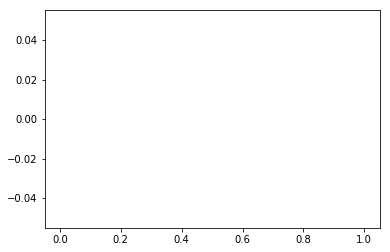

In [29]:
plt.hist(batch_len_list, bins=50)

In [30]:
len(x_batch)

9

In [31]:
dev_loss_array.shape

(1, 1, 2)

ValueError: x and y must have same first dimension, but have shapes (2,) and (8,)

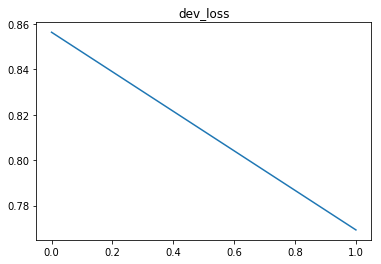

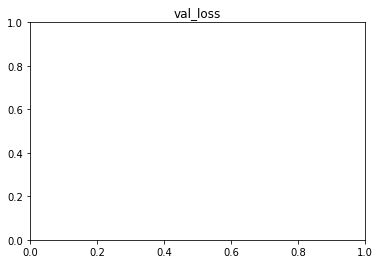

In [32]:
N_FOLDS_TRAINED = 2
plt.figure()
plt.title('dev_loss')
for i_seed in range(n_seeds):
    for dev_loss in dev_loss_array[i_seed, :N_FOLDS_TRAINED]:
        plt.plot(range(n_epochs), dev_loss)

plt.figure()
plt.title('val_loss')
for i_seed in range(n_seeds):
    for loss in val_loss_array[i_seed, :N_FOLDS_TRAINED]:
        plt.plot(range(n_epochs), loss)
        
plt.figure()
plt.title('val_auc')
for i_seed in range(n_seeds):
    for loss in auc_array[i_seed, :N_FOLDS_TRAINED]:
        plt.plot(range(n_epochs), loss)

In [ ]:
valid_index_list = []
kf = KFold(n_splits=n_splits, shuffle=True, random_state=1999)
for i_fold, (dev_index, val_index) in enumerate(kf.split(x_train_indexed)):
    if i_fold >= 2:
        break
    
    valid_index_list.append(val_index)
    

In [ ]:
oof_train.shape

In [ ]:
if DEBUG:
    valid_df = train.iloc[:DEBUG_DATA_SIZE]
else:
    valid_df = train
from IPython.display import display

valid_index = np.concatenate(valid_index_list)

valid_df = valid_df.iloc[valid_index]
oof_train = oof_train[:, :, valid_index]

def last_n_ensemble(start_epoch, end_epoch=n_epochs):
    print()
    print(f'last {n_epochs - start_epoch}')
    weighted_auc_list = []
    for oof_seed in oof_train:
        oof_last = np.mean(oof_seed[start_epoch:end_epoch], axis=0)
        weighted_auc, overall_auc, bias_df = get_various_auc(valid_df, oof_last)
        weighted_auc_list.append(weighted_auc)
    print(f'weighted auc: mean: {np.mean(weighted_auc_list): 0.4f}, std: {np.std(weighted_auc_list): 0.4f}')
    print(f'overall auc: mean: {np.mean(overall_auc): 0.4f}, std: {np.std(overall_auc): 0.4f}')
    return np.mean(weighted_auc_list)

best_auc = 0
for start_epoch in range(n_epochs):
    w_auc = last_n_ensemble(start_epoch)
    if w_auc > best_auc:
        best_auc = w_auc
        best_epoch = start_epoch
    gc.collect()
                                                                                                            
print('\n Searched for best start epoch.')
print(f'Best start epoch: {best_epoch}, Best weighted auc: {best_auc}')

best_start_epoch = best_epoch
best_auc = 0
best_end_epoch = best_start_epoch + 1
for end_epoch in range(best_start_epoch+1, n_epochs):
    w_auc = last_n_ensemble(best_start_epoch, end_epoch)                                                                                              
    if w_auc > best_auc:
        best_auc = w_auc
        best_end_epoch = end_epoch
    gc.collect()
    
print('\n Searched for best end epoch.')
print(f'Best end epoch: {best_end_epoch}, Best weighted auc: {best_auc}')